 # Worm Analysis
 
 This code is written by Gabriel Nützi, gnuetzi (at) gmail (døt) com.    
 Its released under GPL 3.0 License
 
 It was written for biological engineering problems where worms needed to be analyzed from a set of pictures. 

In [3]:
import os,re,itertools
    
import colorsys
import random

from attrdict import AttrMap
import collections

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import numpy as np
import scipy as scp

from skimage import *
import skimage.io
import skimage.morphology as morphology

import glob2

mpl.rcParams['figure.figsize'] = (12.0, 8.0)

%matplotlib notebook

def loadImage(f):
    return skimage.img_as_float(skimage.io.imread(f))

## Skeletonize Image

(500, 500)


/usr/local/lib/python3.5/site-packages/skimage/util/dtype.py:106: UserWarning: Possible sign loss when converting negative image of type float64 to positive image of type bool.
  "%s to positive image of type %s." % (dtypeobj_in, dtypeobj))
/usr/local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to bool
  "%s to %s" % (dtypeobj_in, dtypeobj))


<IPython.core.display.Javascript object>


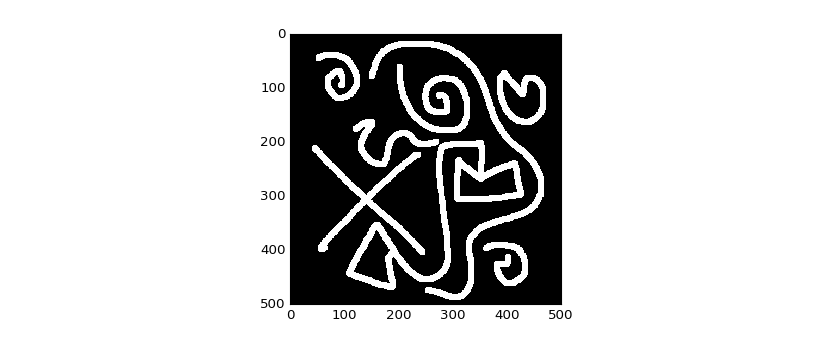

<IPython.core.display.Javascript object>


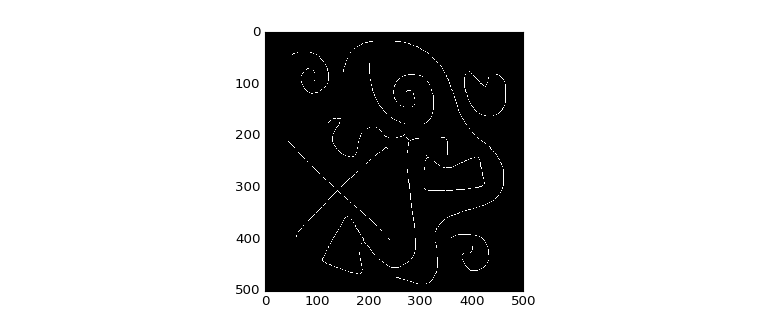

In [4]:
testImage = "wormTest9"
img = img_as_bool(loadImage(testImage + ".jpg"))

print(img.shape)
plt.figure(figsize=(6,2))
plt.imshow(img, cmap=cm.gray, interpolation="nearest")

# do some closing (noise removing)
d = morphology.disk(2);
img = morphology.binary_closing(img,selem=d)

# do the skeletonization
imgSk = morphology.medial_axis(img)

plt.figure(figsize=(6,4))
plt.imshow(imgSk, cmap=cm.gray, interpolation="nearest")
plt.show()

## Tree Definitions

In [5]:
class Vertex:
    def __init__(self,point, degree=0, edges=None):
        self.point= np.asarray(point)
        self.degree=degree
        self.edges=[]
        self.visited=False
        if edges is not None:
            self.edges=edges
    
    def __str__(self):
        return str(self.point)
    
class Edge:
    
    def __init__(self,start,end=None,pixels=None):
        self.start=start
        self.end=end
        self.pixels = []
        if pixels is not None:
            self.pixels=pixels
        self.visited=False

import collections
import networkx as nx

In [6]:
def buildTree(img,start=None):
       
    # copy image since we set visited pixels to black
    img = img.copy()
    shape = img.shape
    nWhitePixels = np.sum(img)
    
    # neighbor offsets (8 nbors)
    nbPxOff = np.array([ [-1,-1], [-1,0] , [-1,1] ,
                        [0,-1] ,          [0,1]  ,
                        [1,-1] , [1,0]  , [1,1]
                      ])
    
    queue = collections.deque()
    
    # a list of all graphs extracted from the skeleton
    graphs = []
    
    blackedPixels = 0
    # we build our graph as long as we have not blacked all white pixels!
    while nWhitePixels != blackedPixels:
         
        # if start not given: determine the first white pixel
        if start is None:
            it = np.nditer(img, flags=['multi_index'])
            while not it[0]:
                it.iternext()

            start = it.multi_index
        
        startV = Vertex(start)
        queue.append(startV)
        print("Start vertex: ", startV)
         
        # set start pixel to False (visited)
        img[startV.point[0],startV.point[1]] = False
        blackedPixels +=1
            
        # create a new graph
        G=nx.Graph()
        G.add_node(startV)
        
        # build graph in a breath-first manner by adding 
        # new nodes to the right and popping handled nodes to the left in queue
        while len(queue):
            currV = queue[0]; # get current vertex
            #print("Current vertex: ", currV)

            # check all neigboor pixels 
            for nbOff in nbPxOff:
                
                # pixel index
                pxIdx = currV.point + nbOff

                if (pxIdx[0] < 0 or pxIdx[0] >= shape[0]) or (pxIdx[1] < 0 or pxIdx[1] >= shape[1]):
                    continue; # current neigbor pixel out of image

                if img[pxIdx[0],pxIdx[1]] :
                    #print( "nb: ", pxIdx, " white ")
                    # pixel is white
                    newV = Vertex( [pxIdx[0],pxIdx[1]] )
                    
                    # add edge from currV <-> newV
                    G.add_edge(currV,newV, object=Edge(currV,newV))
                    #G.add_edge(newV,currV)

                    # add node newV
                    G.add_node(newV)

                    # push vertex to queue
                    queue.append(newV)

                    # set neighbor pixel to black
                    img[pxIdx[0],pxIdx[1]] = False
                    blackedPixels +=1

            # pop currV
            queue.popleft()
        #end while
        
        # empty queue 
        # current graph is finished ->store it
        graphs.append(G)
        
        # reset start
        start = None
        
    #end while
        
    return graphs, img

def getEndNodes(g):
    return [ n for n in nx.nodes_iter(g) if nx.degree(g,n) == 1 ]

### Test Tree Building

In [7]:
# Find a start pixel (not necessary)
y=int(imgSk.shape[1]/2)
x=np.where(imgSk[:,y]==True)[0][0]

# disconnect 
imgSkT = imgSk.copy()
# imgSkT[59,117] = False

graphs , imgB = buildTree(imgSkT,np.array([x,y]))
print("built %i graphs" % len(graphs))

# set all connectivity
for i,g in enumerate(graphs):
    endNodes = getEndNodes(g)
    print("graph %i: %i end nodes" % (i,len(endNodes)))
    graphs[i] = {"graph": g, "endNodes":endNodes}

Start vertex:  [ 19 250]
Start vertex:  [40 64]
Start vertex:  [ 62 201]
Start vertex:  [ 77 394]
Start vertex:  [166 148]
Start vertex:  [211  44]
Start vertex:  [391 372]
built 7 graphs
graph 0: 2 end nodes
graph 1: 2 end nodes
graph 2: 2 end nodes
graph 3: 3 end nodes
graph 4: 8 end nodes
graph 5: 4 end nodes
graph 6: 2 end nodes


<IPython.core.display.Javascript object>


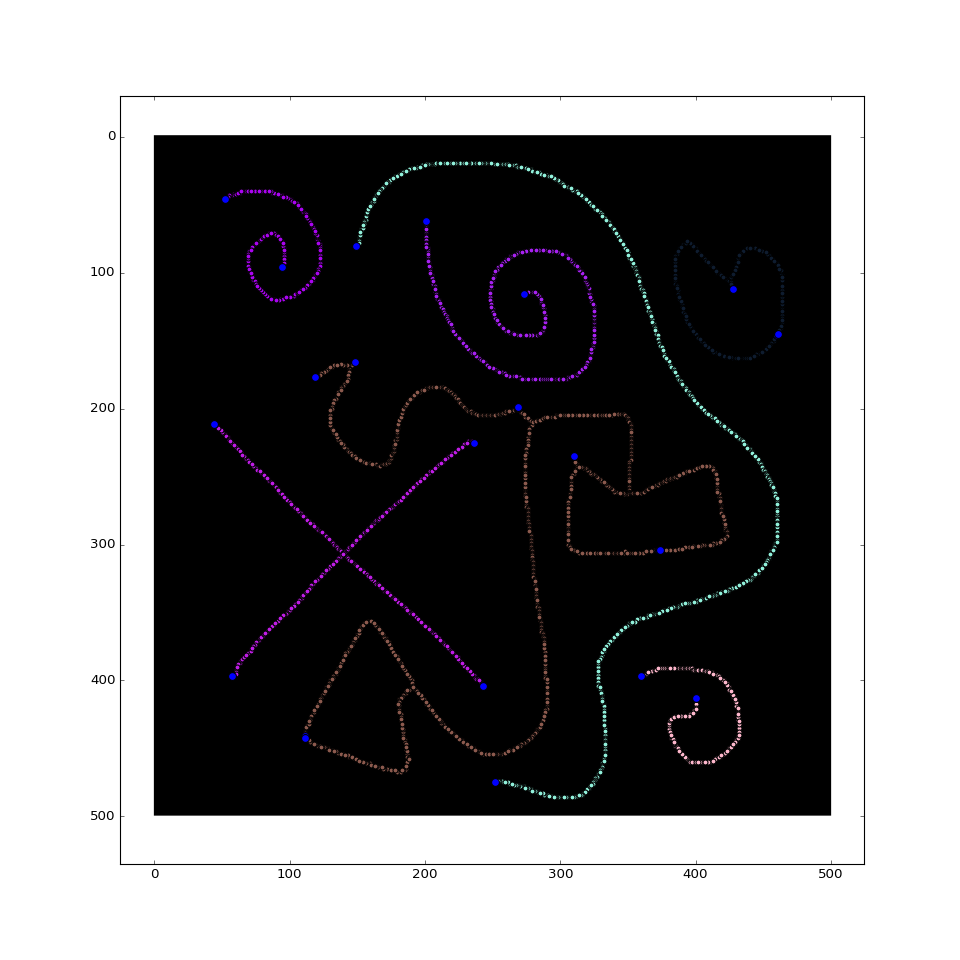

In [8]:
# draw all graphs
fig=plt.figure(figsize=(12,12))

plt.imshow(imgSk, cmap=cm.gray,interpolation='nearest')
ax = plt.gca()
plt.axis("equal")

class PosWrapper(dict):
     def __getitem__(self,key):
        return [key.point[1], key.point[0]] # switch x and y

for i,g in enumerate(graphs):
    nx.draw_networkx(g["graph"],PosWrapper(), ax=ax, 
                     with_labels=False, 
                     node_color="#%06x" % random.randint(0, 0xFFFFFF), 
                     edge_color='b' , node_size=20
                     )
    
    nx.draw_networkx(g["graph"],nodelist = g["endNodes"], pos=PosWrapper(), ax=ax, 
                     with_labels=False, 
                     node_color="b", 
                     edge_color='b' , node_size=50
                     )
    
plt.show()

fig.savefig(testImage +"OutputGraph.pdf")


## Transform Graph
Convert pixel graph into a simpler graph where all line pixels are edges 

In [9]:
def mergeEdges(graph):
    
    # copy the graph
    g = graph.copy()
    
    
    # v0 -----edge 0--- v1 ----edge 1---- v2
    #        pxL0=[]       pxL1=[]           the pixel lists
    #
    # becomes:
    #
    # v0 -----edge 0--- v1 ----edge 1---- v2
    # |_________________________________|
    #               new edge
    #    pxL = pxL0 + [v.point]  + pxL1      the resulting pixel list on the edge
    #    
    # an delete the middle one
    # result:
    #
    # v0 --------- new edge ------------ v2
    #
    # where new edge contains all pixels in between!
    
    
    # start not at degree 2 nodes
    startNodes = [ startN for startN in g.nodes() if nx.degree(g,startN) != 2] 
        
    
    for v0 in startNodes:
        
        # start a line traversal from each neighbor
        startNNbs = nx.neighbors(g,v0);
        
        if not len(startNNbs):
            continue
        
        counter = 0
        v1 = startNNbs[counter] # next nb of v0
        while True :
            
            if nx.degree(g,v1) == 2:
                # we have a node which has 2 edges = this is a line segement
                # make new edge from the two neighbors
                nbs = nx.neighbors(g,v1)
                
                # if the first neihbor is not n, make it so!
                if nbs[0] != v0:
                    nbs.reverse()
                
                
                pxL0 = g[v0][v1]["object"].pixels     # the pixel list of the edge 0
                pxL1 = g[v1][nbs[1]]["object"].pixels # the pixel list of the edge 1

                # fuse the pixel list from right and left and add our pixel n.point
                g.add_edge(v0,nbs[1], 
                           object=Edge(v0,nbs[1],pixels = pxL0 + [ v1.point ] + pxL1 )
                           )

                # delete the node n
                g.remove_node(v1)
                
                # set v1 to new left node
                v1 = nbs[1]
                           
            else:
                counter +=1
                if counter == len(startNNbs):
                    break;
                v1 = startNNbs[counter] # next nb of v0
                                  
    # weight the edges according to their number of pixels
    for u,v,o in g.edges(data="object"):
        g[u][v]["weight"] = len(o.pixels)
        
    return g

def getLongestPath(graph, endNodes):
    """
        graph is a fully reachable graph = every node can be reached from every node
    """
    
    if len(endNodes) < 2:
        raise ValueError("endNodes need to contain at least 2 nodes!")
    
    #get all shortest paths from each endpoint to another endpoint
    allEndPointsComb = itertools.combinations(endNodes, 2)
    
    maxLength = 0
    maxPath = None
    
    for ePoints in allEndPointsComb:
        
        # get shortest path for these end points pairs
        sL = nx.dijkstra_path_length(graph,
                                     source=ePoints[0],
                                     target=ePoints[1])
        
        # dijkstra can throw if now path, but we are sure we have a path 
        
        # store maximum
        if(sL > maxLength):
            maxPath = ePoints
            maxLength = sL 
    
    if maxPath is None:
        raise ValueError("No path found!")
    
    
    return nx.dijkstra_path(graph,
                            source=maxPath[0],
                            target=maxPath[1]) ,  maxLength 
    

In [10]:
simpleGraphs = []
for g in graphs:
    newG = mergeEdges(g["graph"])
    
    simpleGraphs.append(
        { 
            "graph": newG,
            "endNodes": getEndNodes(newG)
        }
    )

for i,g in enumerate(simpleGraphs):
    path = getLongestPath(g["graph"], g["endNodes"] )
    simpleGraphs[i]["longestPath"] = path

## Plot Longest Path

<IPython.core.display.Javascript object>


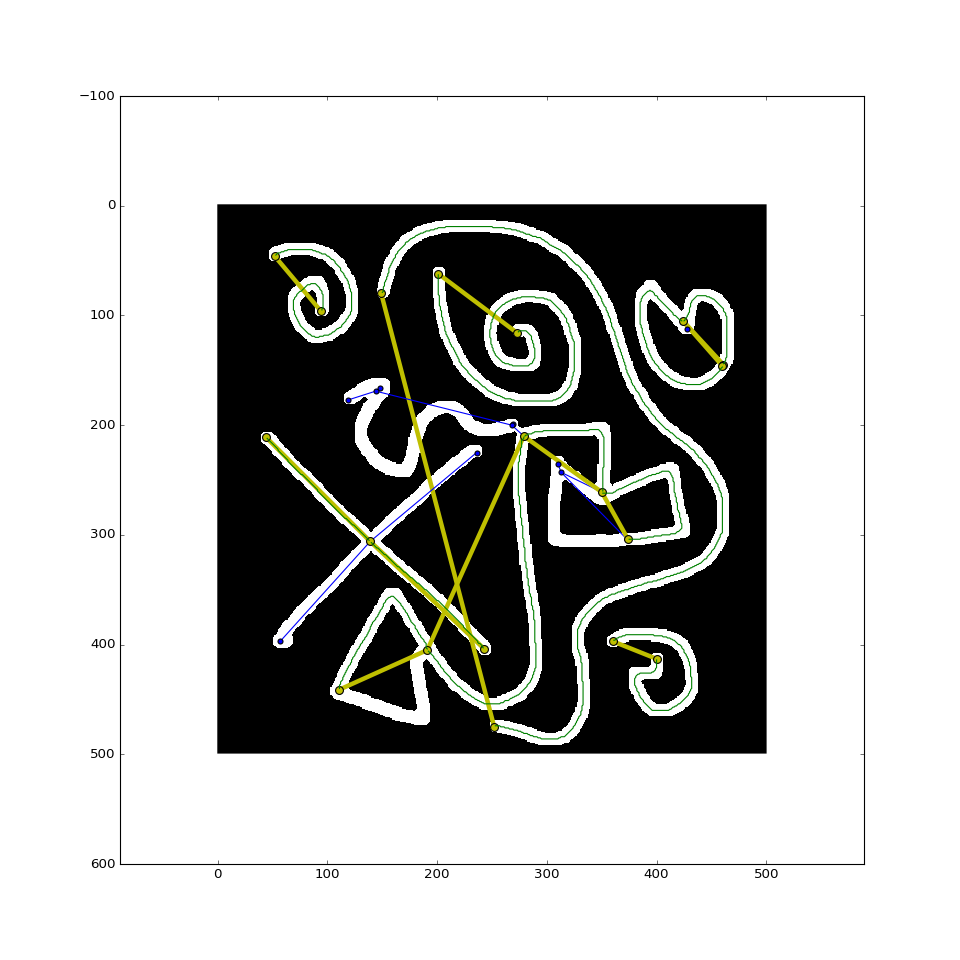

In [11]:
fig=plt.figure(figsize=(12,12))

plt.imshow(img, cmap=cm.gray,interpolation='nearest')
ax = plt.gca()
plt.axis("equal")

for i,g in enumerate(simpleGraphs):
    
    graph = g["graph"]
    
    nx.draw_networkx(graph,PosWrapper(), ax=ax, 
                     with_labels=False, 
                     node_color="b", 
                     edge_color='b' , node_size=20
                     )
    
    longestPathNodes = g["longestPath"][0]
    longestPathEdges = [ (longestPathNodes[i],longestPathNodes[i+1]) for i in range(0,len(longestPathNodes)-1)]

    nx.draw_networkx(graph,PosWrapper(), 
                           nodelist=longestPathNodes , 
                           edgelist=longestPathEdges,
                             ax=ax, 
                             with_labels=False, 
                             node_color="y" , 
                             edge_color='y' , node_size=50,
                             width=4
                     )
    
    # loop over edges and plot pixels inbetween
    for e in longestPathEdges:
        
        px = np.array( graph[e[0]][e[1]]["object"].pixels )

        
        plt.plot( px[:,1], px[:,0], "g" )


fig.savefig(testImage +"OutputSimpleGraph.pdf")